In [2]:
import numpy as np
from numba import njit, jit, vectorize, float64, prange
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
from os.path import exists
from scipy import stats

mpl.rcParams["figure.dpi"] = 300
mpl.rcParams["legend.fontsize"] = 11
mpl.rcParams["font.size"] = 11
plt.rc("text", usetex=False)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [3]:
def sample_mean_variance(array):
    n = len(array)
    assert n > 1
    μ = np.mean(array)
    svar = np.sum(np.power(array - μ, 2))/(n-1)
    return μ, svar

In [4]:
def confidence_intervals(sample_variances, p):
    """
    Returns the 100(1-p)% confidence intervals
    sample_variances    ----------
    sample_variances: array
        array of sample variances
    
    p: float between 0 and 1 exclusive
        p-value for confidence interval
        
    Returns
    -------
    intervals: array of floats
        |x - μ| < intervals, where X is the sample mean
        
    Notes
    -----
    Calculated as
        `stats.t.ppf(q = 1 - p/2, df=n-1) * np.sqrt(sample_variances)/np.sqrt(n)`
    where n = `len(sample_variances)`
    """
    n = len(sample_variances)
    intervals = stats.t.ppf(q = 1 - p/2, df=n-1) * np.sqrt(sample_variances)/np.sqrt(n)
    return intervals

In [5]:
@njit
def random_uniform(low = 0.0, high = 1.0, size = 1, seed = 0):
    if (seed):
        np.random.seed(seed)
        
    randos = np.random.random(size = size)
    scale = np.abs(high - low)
    randos *= scale
    randos += low
    return randos

@njit
def random_uniform_orthogonal(nax, l_bounds, u_bounds, seed = 0):
    """
    TODO: license
    TODO: docstring
    TODO: seeding?
    """
    if (seed):
        np.random.seed(seed)
        
    N = np.power(nax, 2)
    x_scale = (u_bounds[0] - l_bounds[0])/N
    y_scale = (u_bounds[1] - l_bounds[1])/N
    x0 = l_bounds[0]
    y0 = l_bounds[1]
    xlist = np.arange(N).reshape((nax,nax))
    ylist = np.arange(N).reshape((nax,nax))
    x_randos = np.empty(N, dtype = np.float64)
    y_randos = np.empty(N, dtype = np.float64)
    for i in range(nax):
        xlist[i] = np.random.permutation(xlist[i])
        ylist[i] = np.random.permutation(ylist[i])
    for i in range(nax):
        for j in range(nax):
            x_randos[i*nax + j] = x0 + x_scale * (xlist[i][j] + (np.random.random()))
            y_randos[i*nax + j] = y0 + y_scale * (ylist[j][i] + (np.random.random()))
    return x_randos, y_randos

In [6]:
@jit(nopython = True)
def default_escape_cond(z):
    return np.abs(z) >= 2

@jit(nopython = True)
def main_cardioid(arg):
    point = 0.5 * np.exp(1j*arg) - 0.25 * np.exp(2*1j*arg)
    return np.abs(point)

#@jit(nopython = True)
#def cardioid_escape_cond(z):
    #if np.abs(z) <= main_cardioid(z.)

def mandelbrot_batch_factory(escape_condition):
    @jit(nopython = True, parallel = True, nogil = True)
    def _mandelbrot_mc(max_iter, samples):
        iter_counts = np.empty(len(samples), dtype = np.int64)
        for i in prange(len(samples)):
            c = samples[i]
            zn = c
            for count in range(max_iter):
                zn = zn * zn + c
                if (escape_condition(zn)):
                    iter_counts[i] = count
                    break
                elif count == max_iter - 1:
                    iter_counts[i] = count
        return iter_counts
    return _mandelbrot_mc

mandelbrot_mc_default = mandelbrot_batch_factory(default_escape_cond)

@njit
def create_batch_uniform(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        np.random.seed(seed)
    samples_re = random_uniform(low = re_low, high = re_high, size = N)
    samples_im = random_uniform(low = im_low, high = im_high, size = N)
    samples = samples_re + 1j*samples_im
    return samples

@njit
def create_batch_orthogonal(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        np.random.seed(seed)
    nax = np.int64(np.ceil(np.sqrt(N)))
    l_bounds = (re_low, im_low)
    u_bounds = (re_high, im_high)
    samples_re, samples_im = random_uniform_orthogonal(nax, l_bounds, u_bounds)
    samples = samples_re + 1j*samples_im
    np.random.shuffle(samples)
    samples = samples[:N]
    return samples

def create_batch_lhc(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        sampler = stats.qmc.LatinHypercube(d = 2, seed = seed)
    else:
        sampler = stats.qmc.LatinHypercube(d = 2)
    re_scale = re_high - re_low
    im_scale = im_high - im_low
    samples = sampler.random(N)
    samples[:,0] *= re_scale
    samples[:,1] *= im_scale
    samples[:,0] += re_low
    samples[:,1] += im_low
    samples = samples[:,0] + 1j*samples[:,1]
    return samples

def create_batch_sobol(N, re_low, re_high, im_low, im_high, seed = 0):
    if (seed):
        sampler = stats.qmc.Sobol(d = 2, seed = seed)
    else:
        sampler = stats.qmc.Sobol(d = 2)
    l_bounds = [re_low, im_low]
    u_bounds = [re_high, im_high]
    
    samples_count = np.int64(np.ceil(np.log2(N)))
    
    samples = sampler.random_base2(samples_count)
    samples = stats.qmc.scale(samples, l_bounds, u_bounds)
    samples = samples[:,0] + 1j*samples[:,1]
    np.random.shuffle(samples)
    samples = samples[:N]
    return samples

@njit
def genrand_uniform(low = 0.0, high = 1.0, size = 1, sampler = random_uniform):
    return sampler(low, high, size)

In [7]:
@njit
def complex_to_real2(cmplx):
    re = np.real(cmplx)
    im = np.imag(cmplx)
    return re, im

In [8]:
np.random.seed(13151)
s = 2**10  # even power of two
re_low, re_high, im_low, im_high = 0, 1, 0, 1
ortho_samples = create_batch_orthogonal(s, re_low, re_high, im_low, im_high, seed = np.random.randint(2**31))
sobol_samples = create_batch_sobol(s, re_low, re_high, im_low, im_high, seed = np.random.randint(2**31))
unifo_samples = create_batch_uniform(s, re_low, re_high, im_low, im_high, seed = np.random.randint(2**31))

In [9]:
unifo_re, unifo_im = complex_to_real2(unifo_samples)
sobol_re, sobol_im = complex_to_real2(sobol_samples)

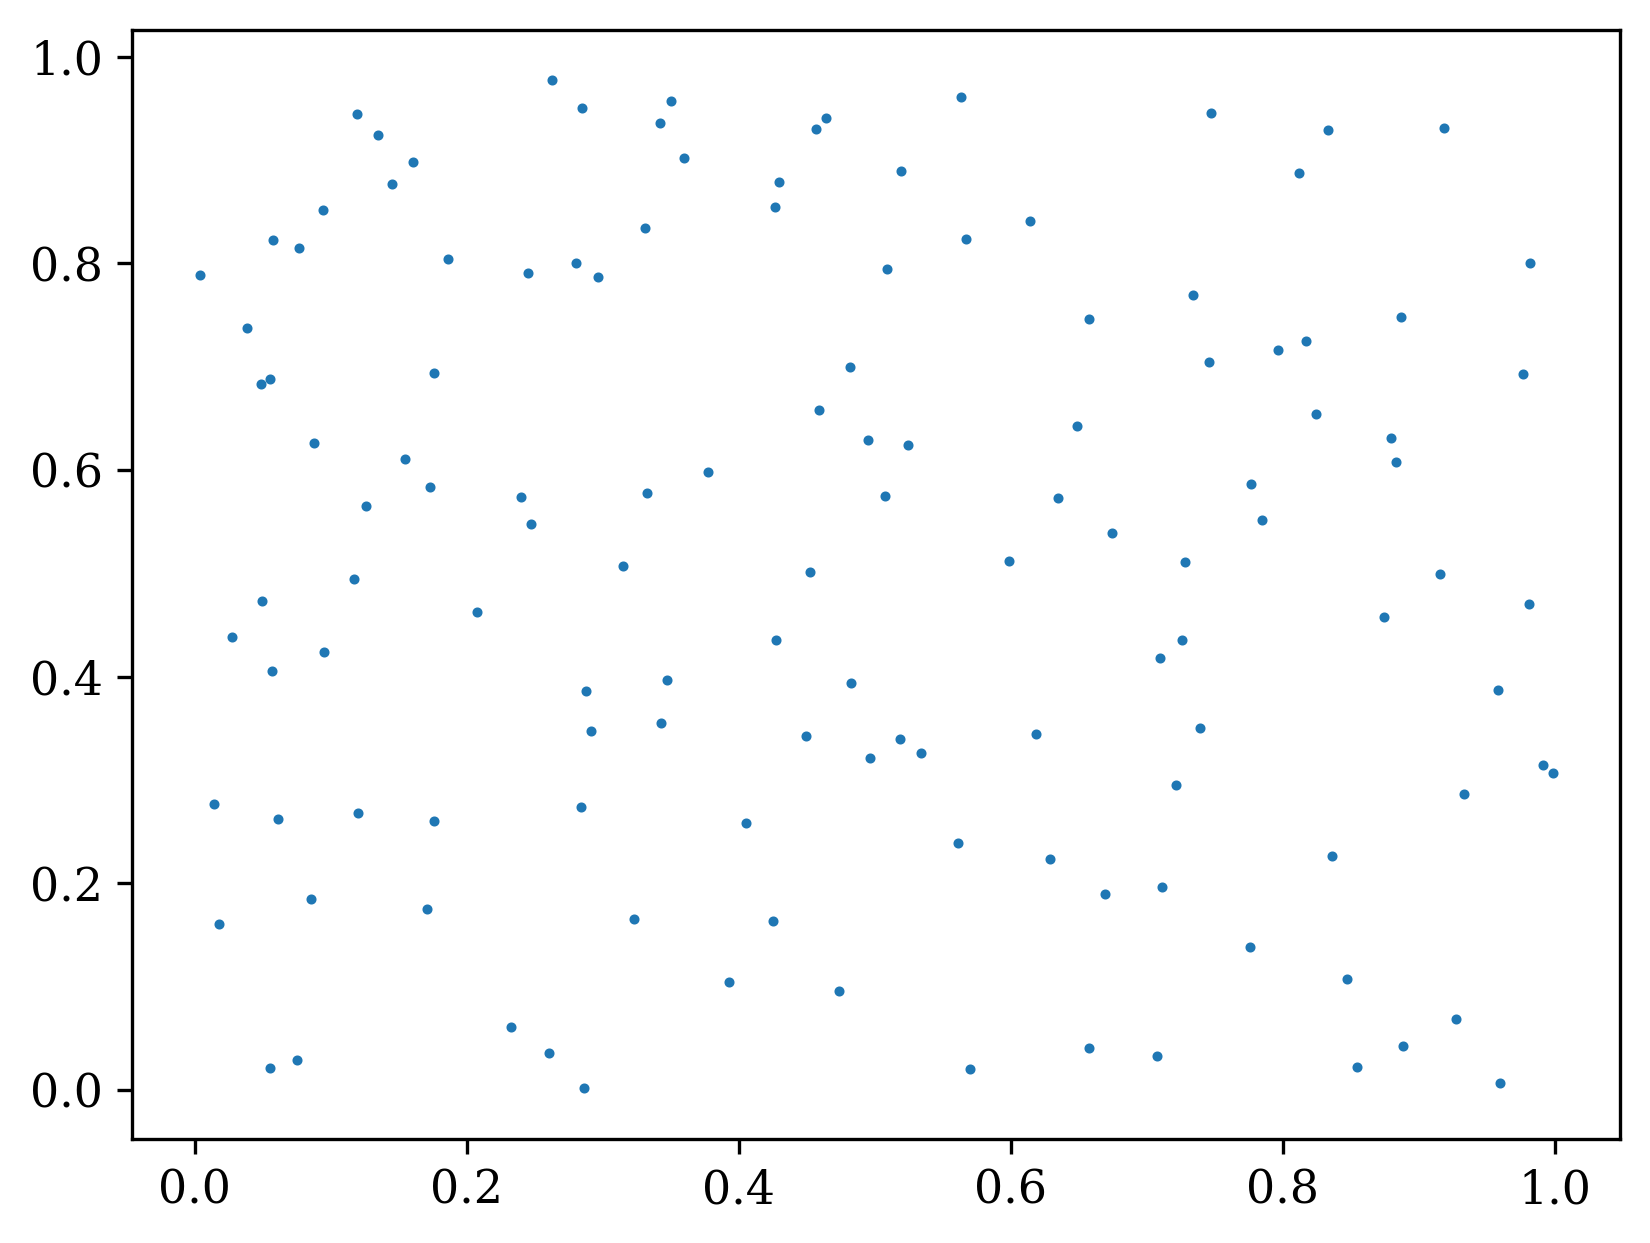

In [10]:
plt.scatter(sobol_re[:128], sobol_im[:128], s = 2)
plt.show()

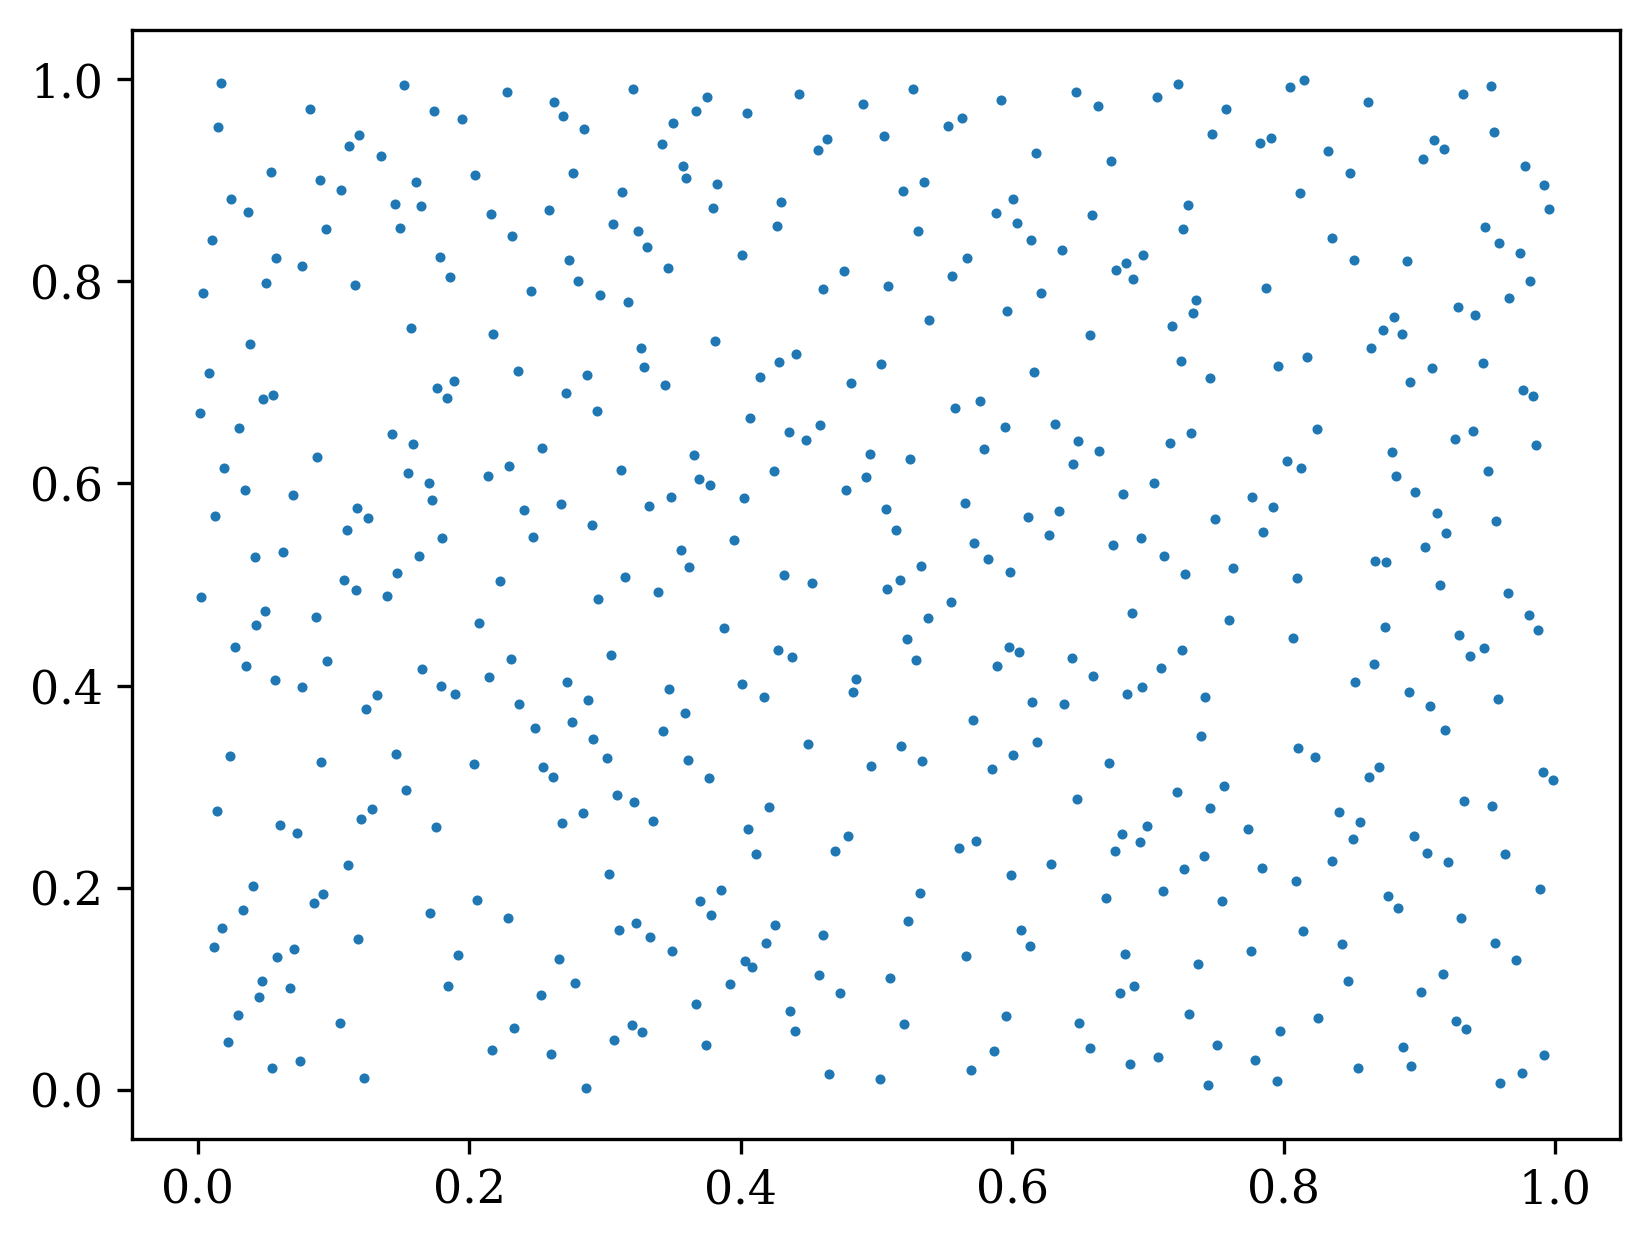

In [11]:
plt.scatter(sobol_re[:512], sobol_im[:512], s = 2)
plt.show()

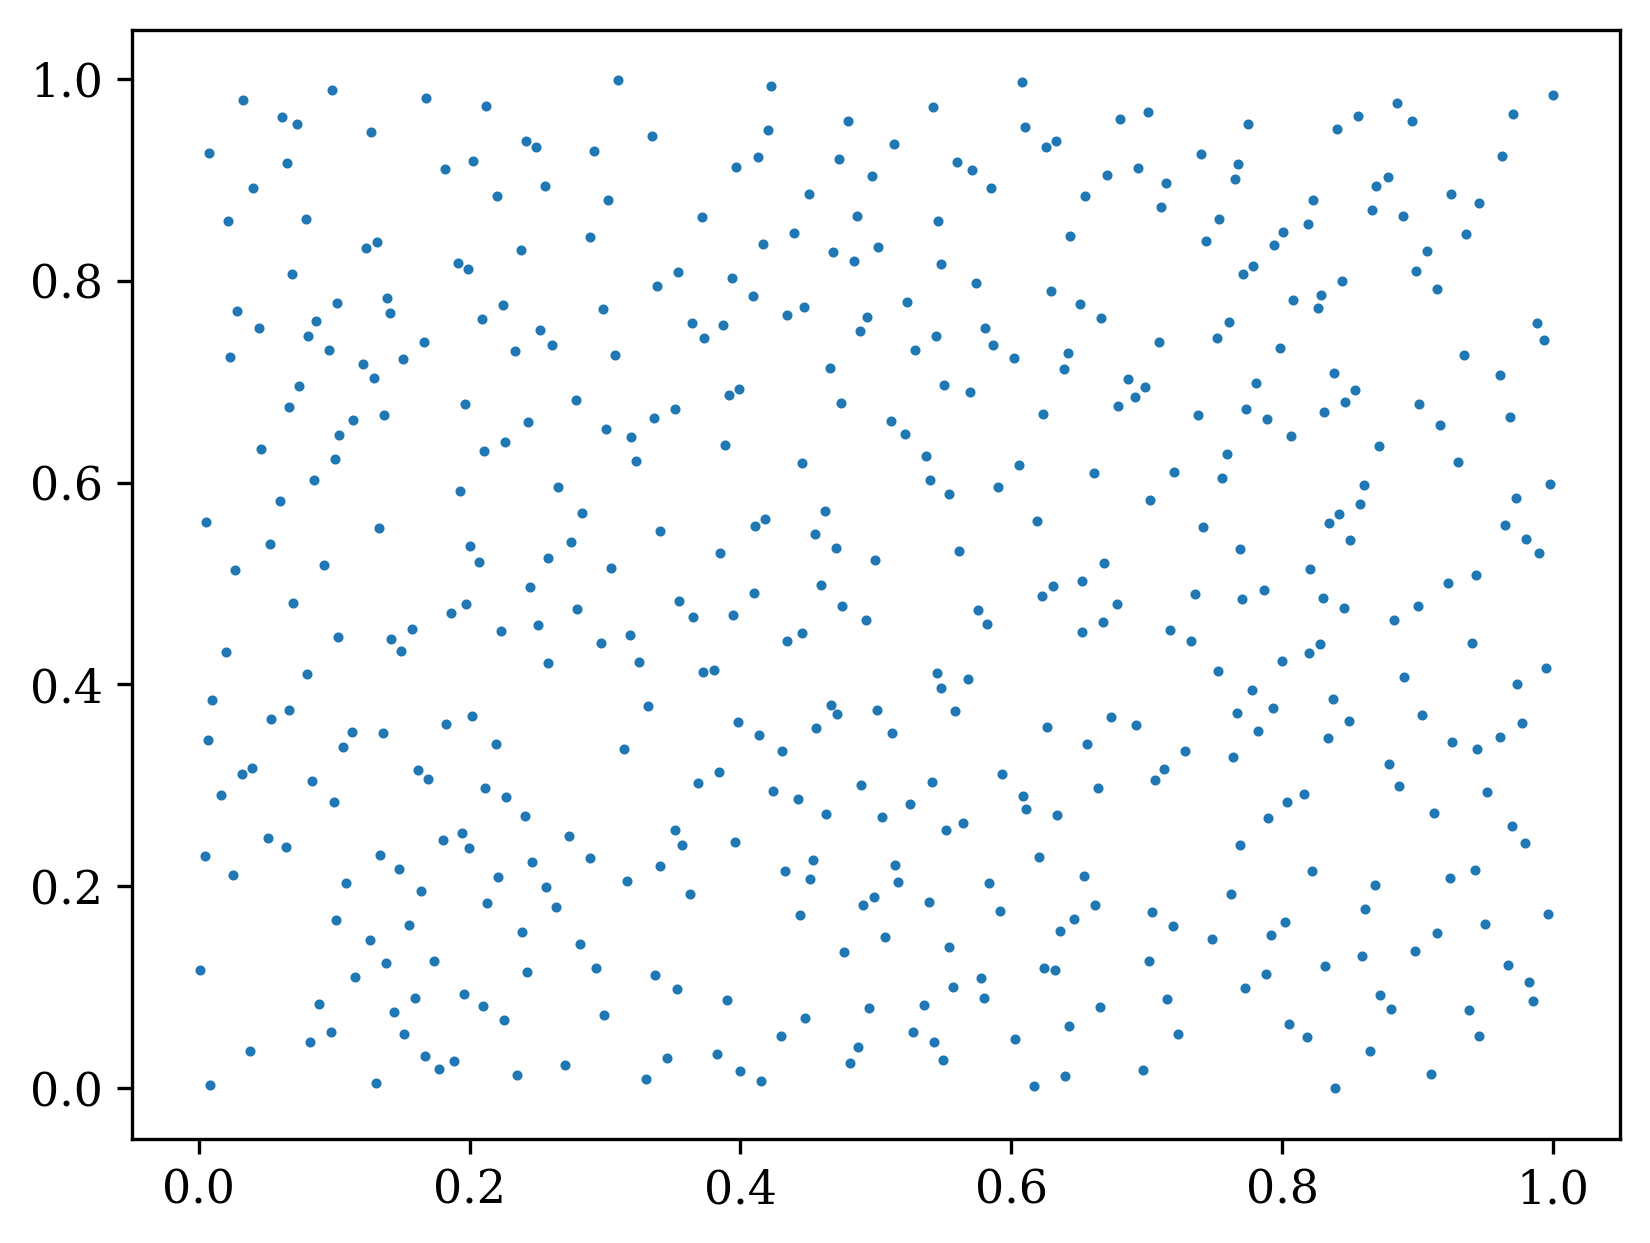

In [12]:
plt.scatter(sobol_re[513:1024], sobol_im[513:1024], s = 2)
plt.show()

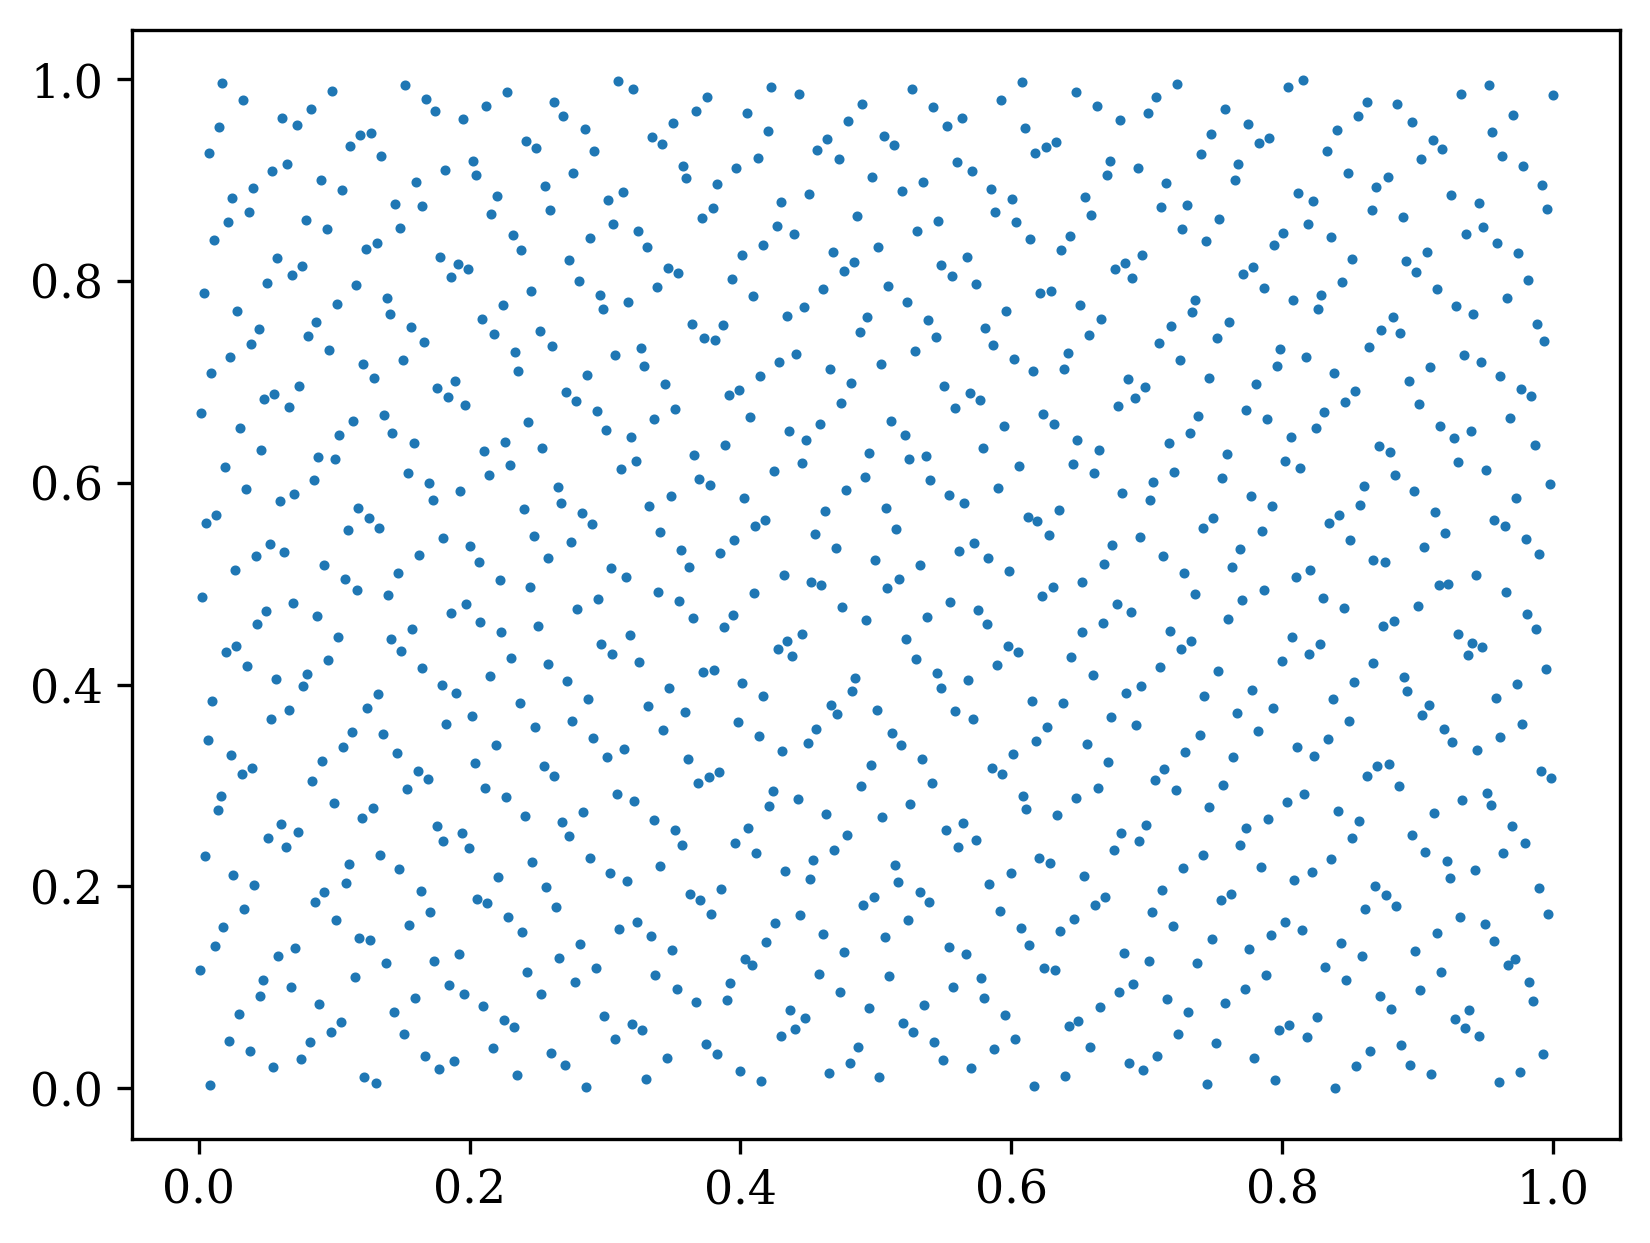

In [13]:
plt.scatter(sobol_re, sobol_im, s = 2)
plt.show()

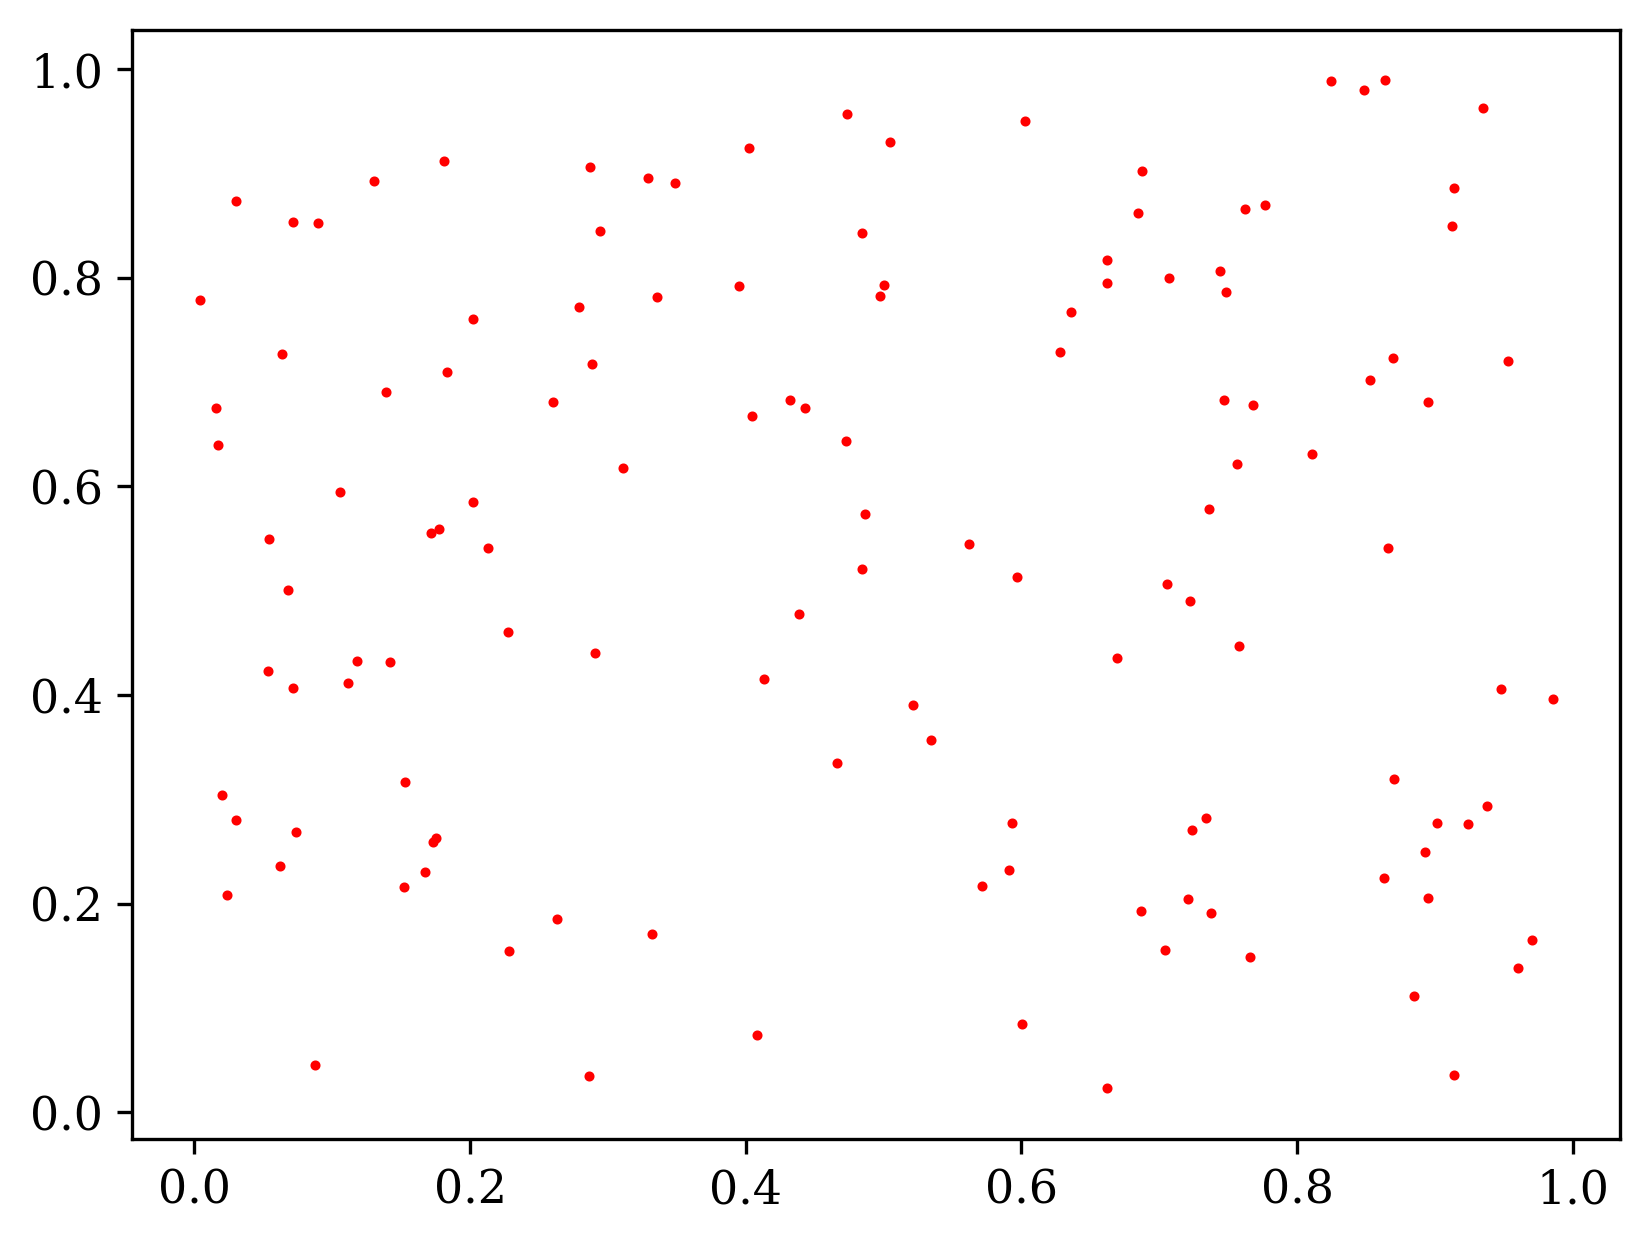

In [14]:
plt.scatter(unifo_re[:128], unifo_im[:128], s = 2, c = 'red')
plt.show()

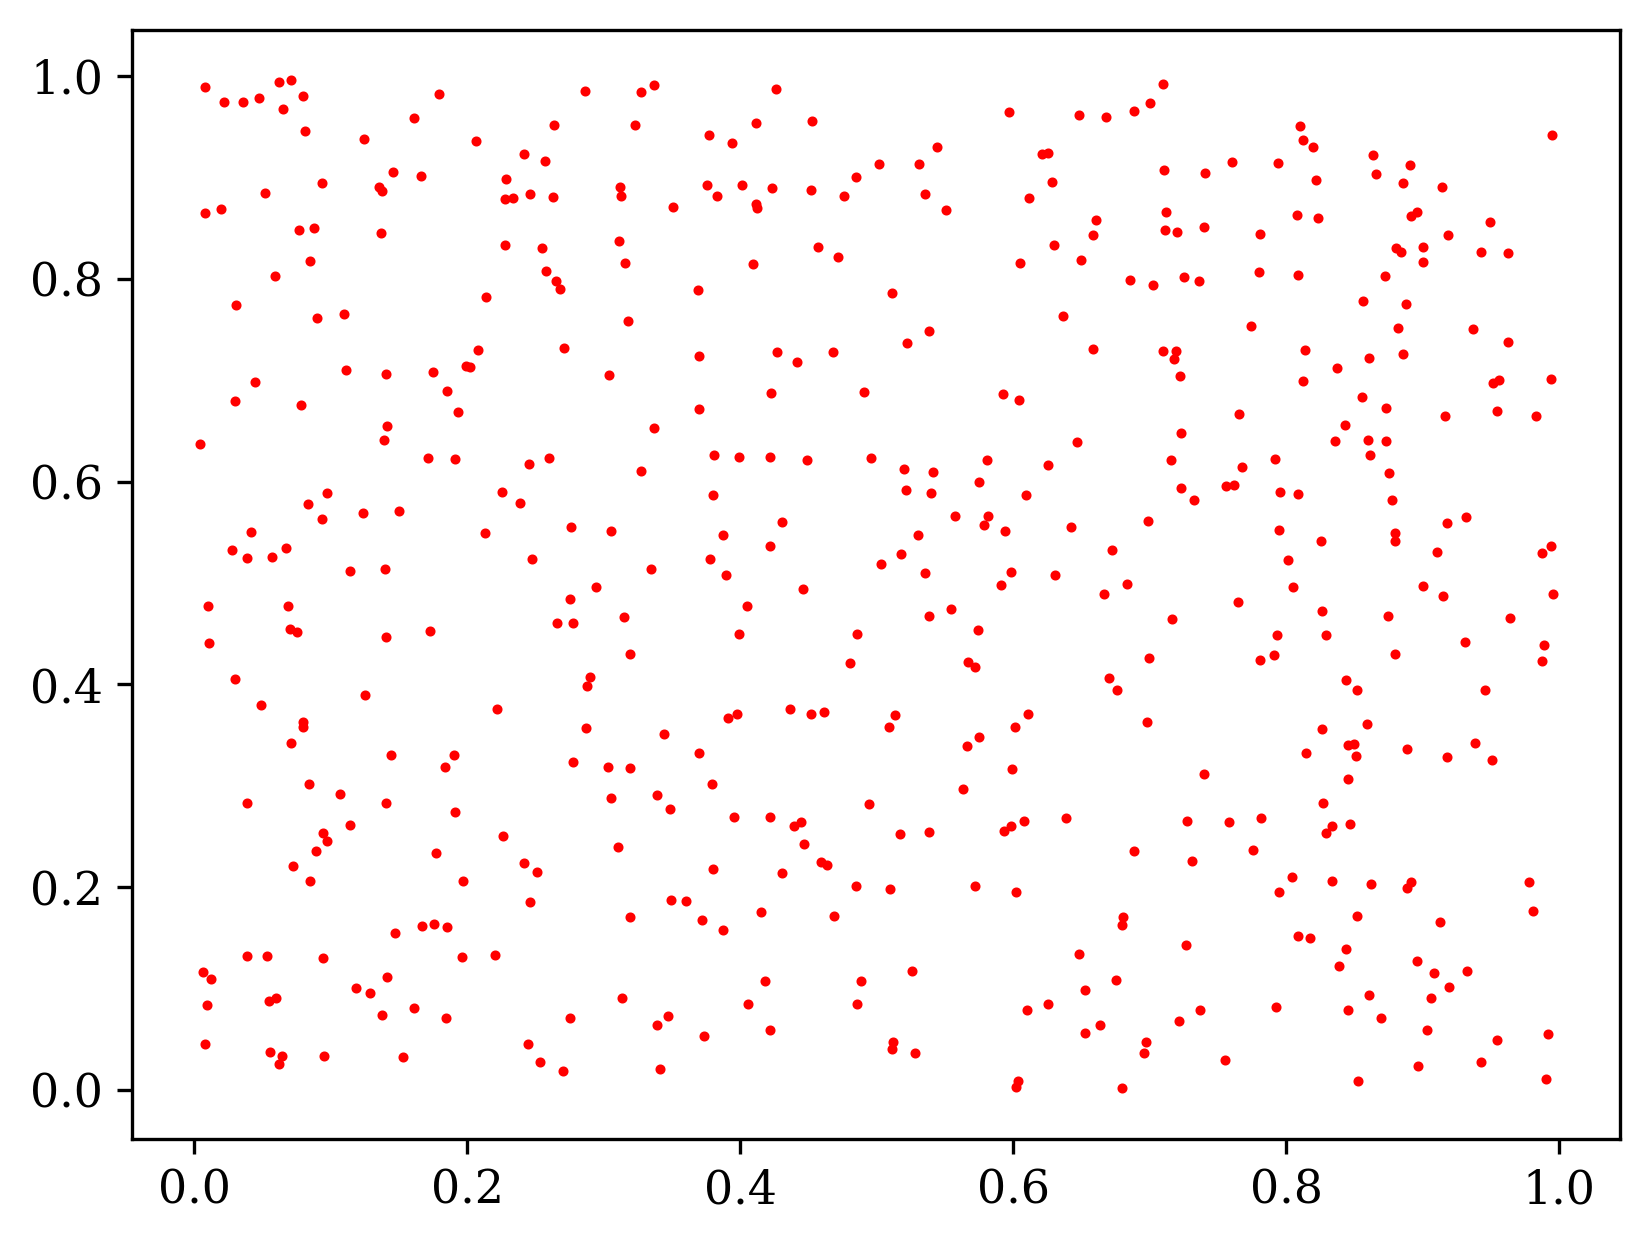

In [15]:
plt.scatter(unifo_re[512:1024], unifo_im[512:1024], s = 2, c = 'red')
plt.show()

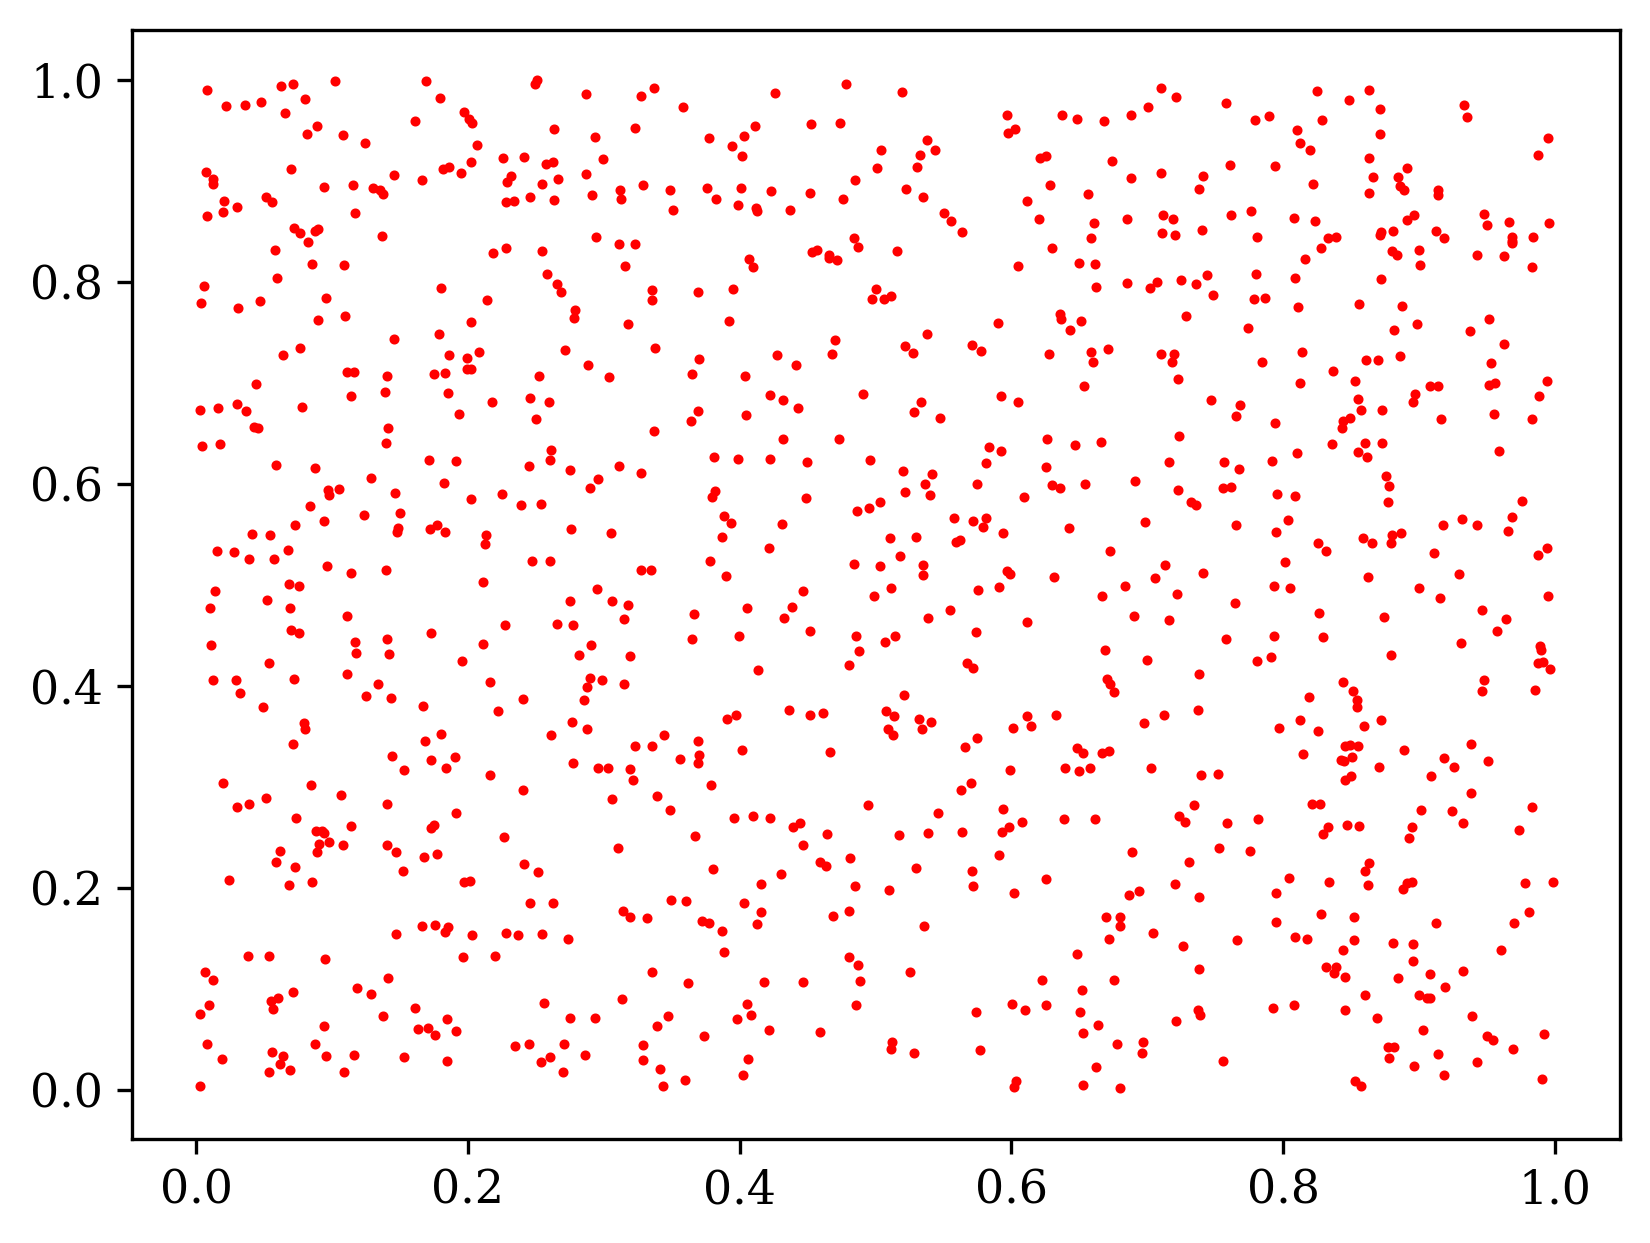

In [16]:
plt.scatter(unifo_re, unifo_im, s = 2, c = "red")
plt.show()

In [17]:
samples_unifo_256 = create_batch_uniform(256, 0, 1, 0, 1, seed = np.random.randint(2**31))
samples_sobol_256 = create_batch_sobol(256, 0, 1, 0, 1, seed = np.random.randint(2**31))
unifo_re_256, unifo_im_256 = complex_to_real2(samples_unifo_256)
sobol_re_256, sobol_im_256 = complex_to_real2(samples_sobol_256)

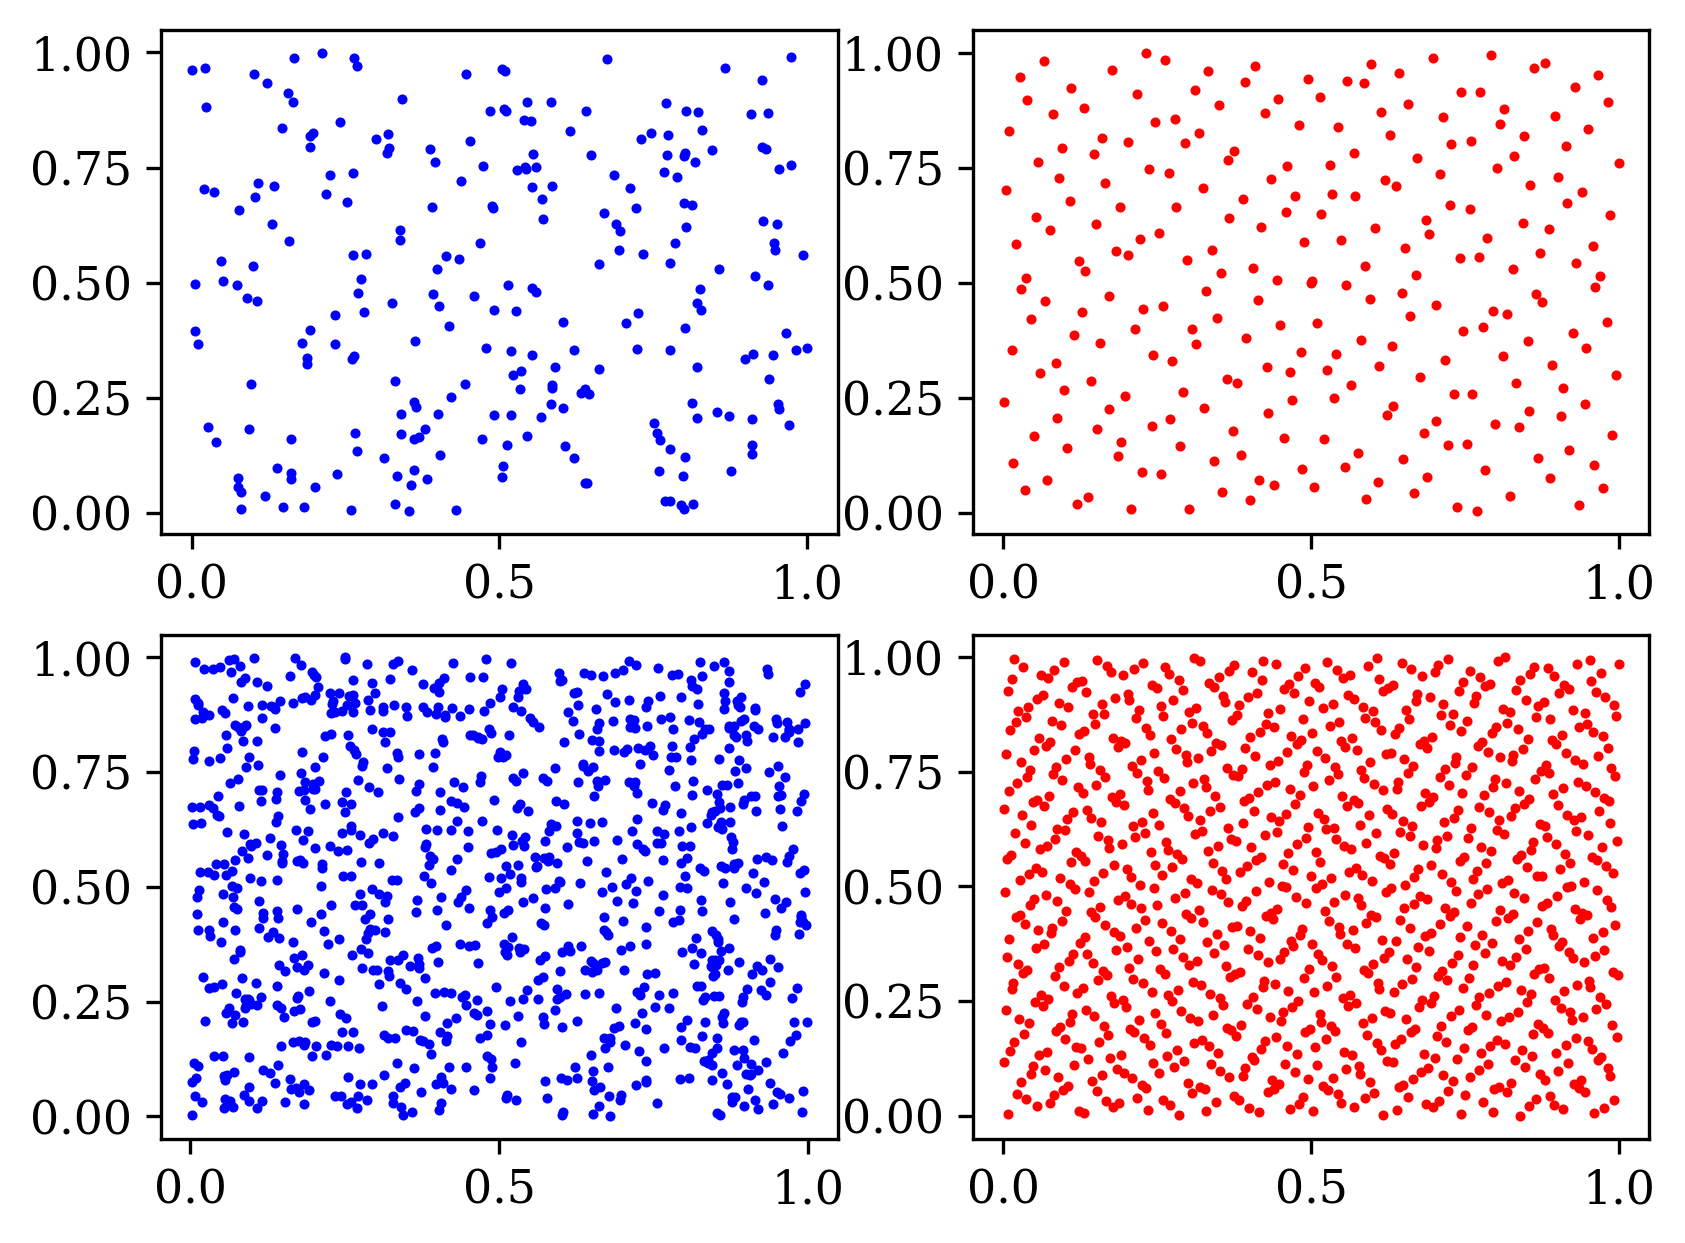

In [18]:
fig, axes = plt.subplots(2,2)
axes[0][0].scatter(unifo_re_256, unifo_im_256, s = 2, c = 'blue')
axes[0][1].scatter(sobol_re_256, sobol_im_256, s = 2, c = 'red')
axes[1][0].scatter(unifo_re, unifo_im, s = 2, c = 'blue')
axes[1][1].scatter(sobol_re, sobol_im, s = 2, c = 'red')
plt.show()

In [19]:
number_of_batches = 50
sample_sizes = np.array([np.power(2,i) for i in range(6,15,2)])
batch_generators = [create_batch_uniform, create_batch_orthogonal, create_batch_sobol]
mean_discrepancies = np.empty((len(batch_generators), len(sample_sizes)))
sample_variances = np.empty((len(batch_generators), len(sample_sizes)))
npz_filename = "discrepancies_unifo_ortho_sobol.npz"
for i, bgen in enumerate(batch_generators):
    for j, s in enumerate(sample_sizes):
        discrepancies_batch = np.empty(number_of_batches)
        for l in range(number_of_batches):
            samples = bgen(s, 0, 1, 0, 1, seed = np.random.randint(2**31))
            samples_R2 = np.stack([np.real(samples), np.imag(samples)], axis = 1)
            dscr = stats.qmc.discrepancy(samples_R2, workers = -1)
            discrepancies_batch[l] = dscr
        μ, svar = sample_mean_variance(discrepancies_batch)
        print(μ)
        mean_discrepancies[i][j] = μ
        sample_variances[i][j] = svar

0.005564325757476372
0.0012041095323601025
0.0003684438160796821
0.0001081951363159872
2.2740728348069617e-05
0.00019918211492065297
1.9381998588050563e-05
2.089713067956467e-06
2.3418683457343547e-07
2.803376252913381e-08
0.00015586524296780534
1.0998636118451088e-05
7.682769497963094e-07
5.2993925092614805e-08
3.6215259013872013e-09


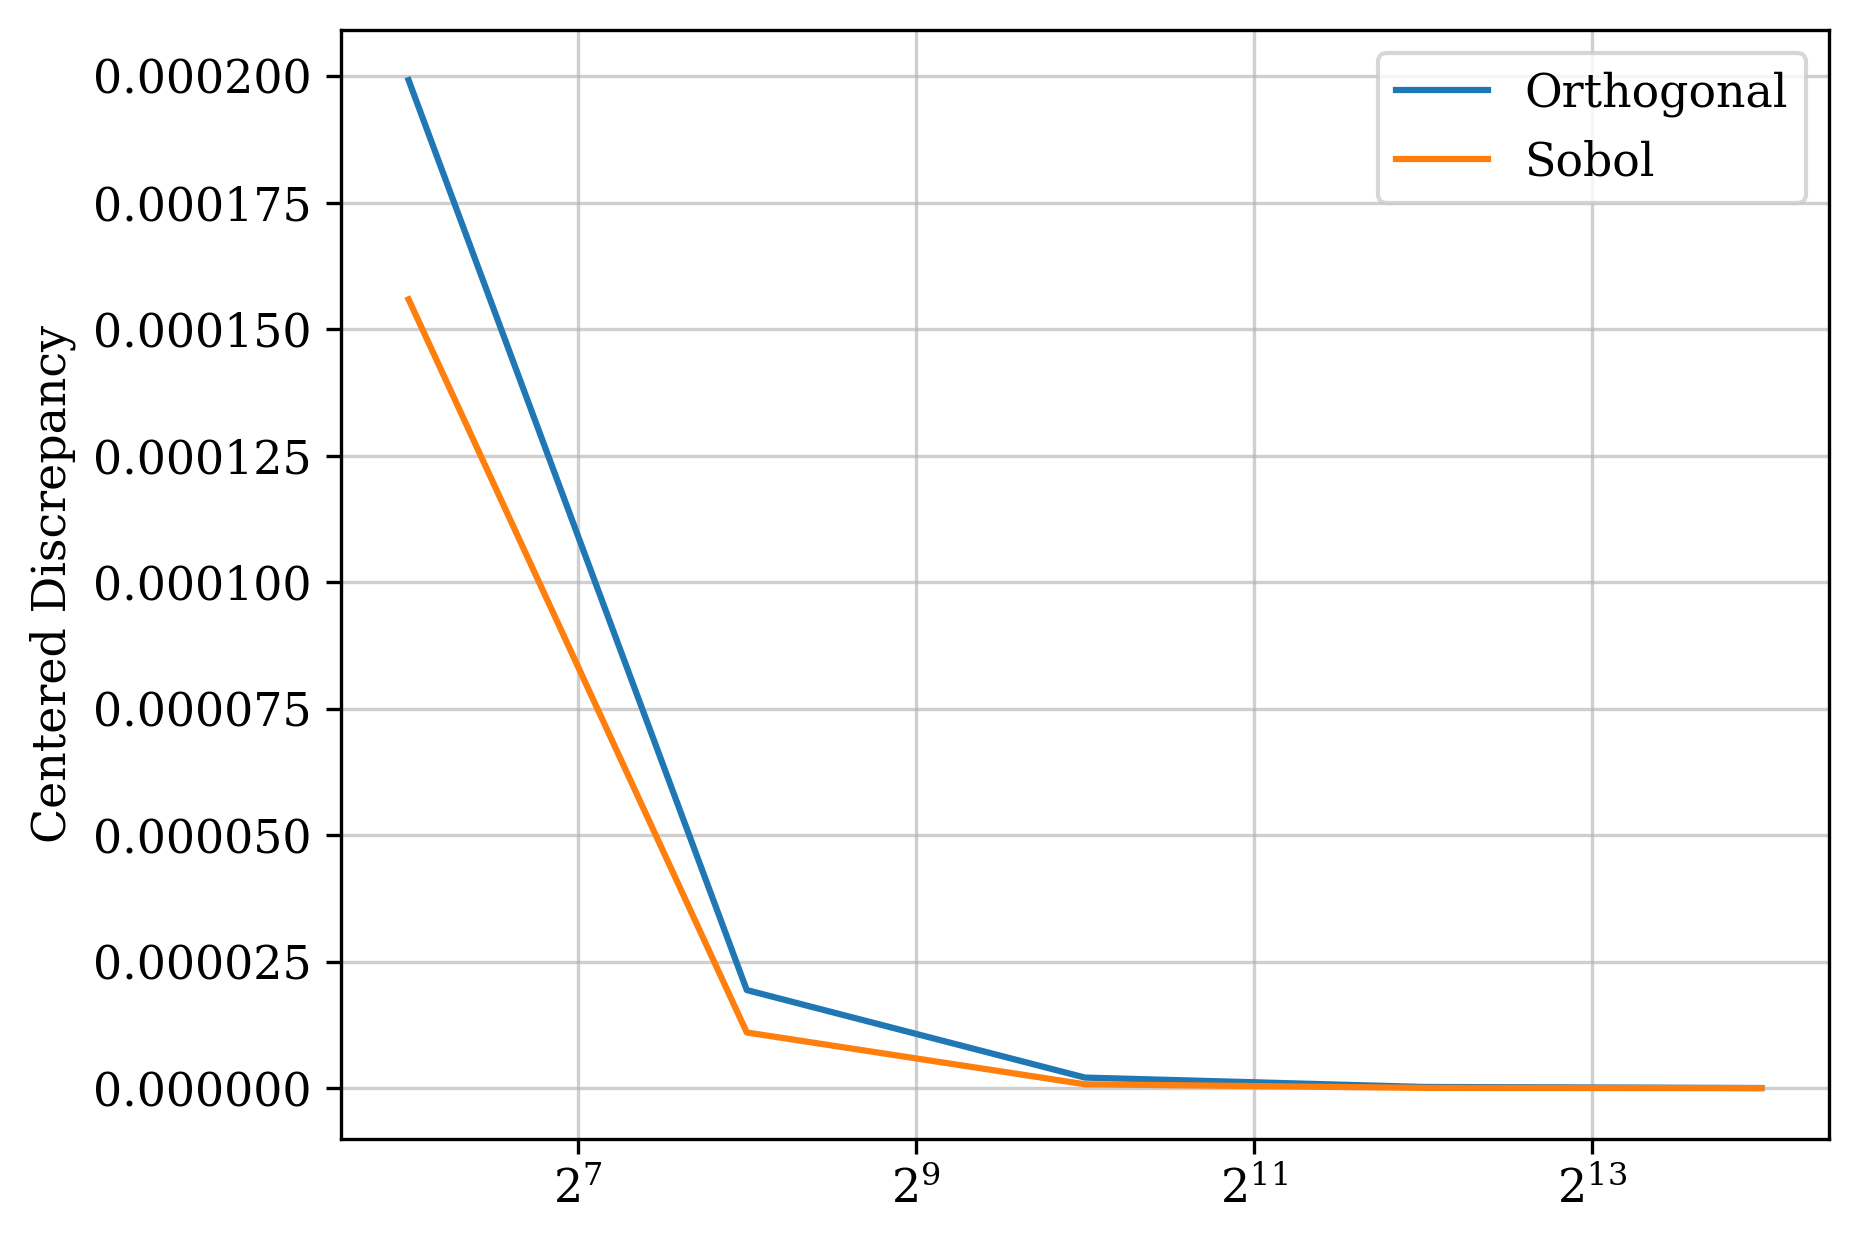

In [25]:
labels = ["IID", "Orthogonal", "Sobol"]
fig, ax = plt.subplots()
for i,discr in enumerate(mean_discrepancies[1:]):
    ax.plot(sample_sizes, discr, label = labels[i+1])
plt.legend()
plt.ylabel("Centered Discrepancy")
plt.xscale("log", base = 2)
plt.grid(alpha = 0.6)
plt.show()

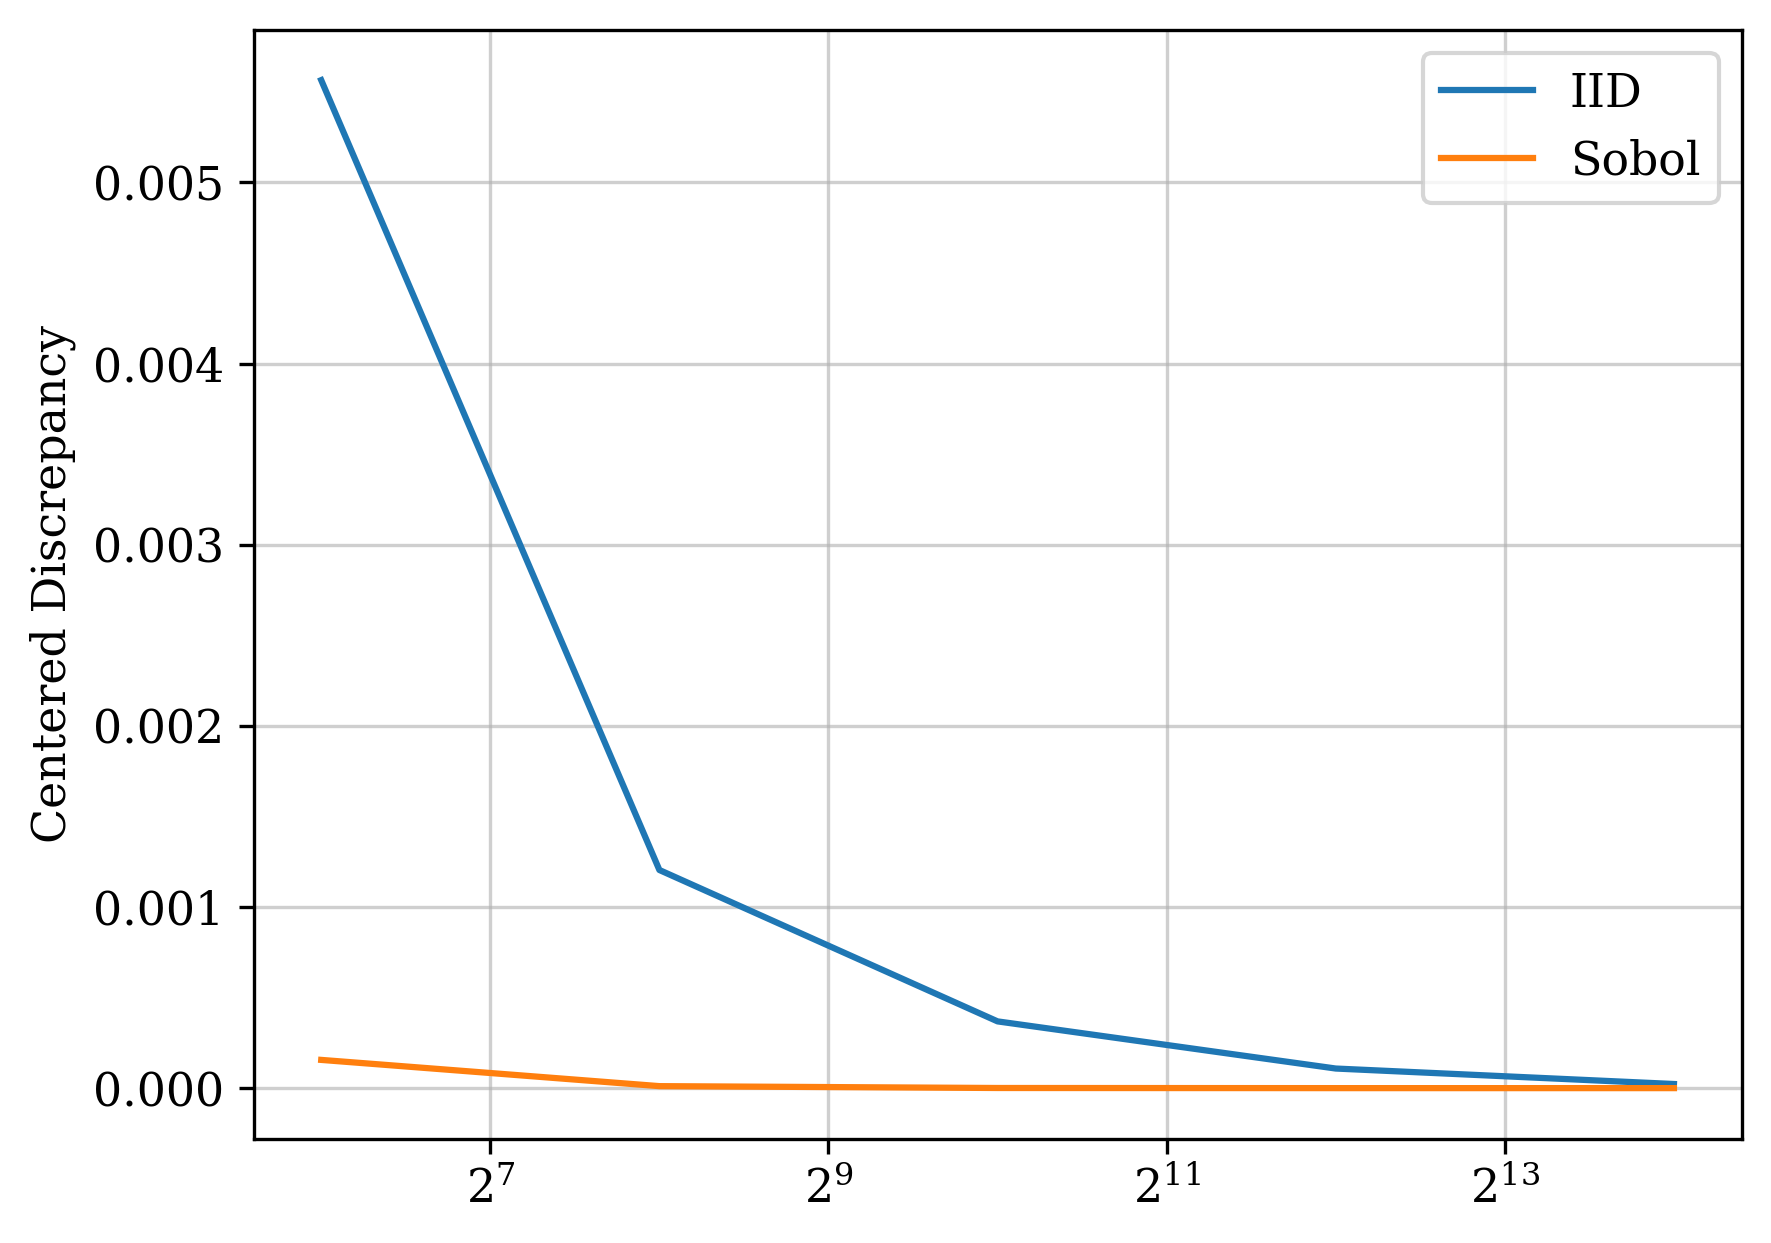

In [26]:
fig, ax = plt.subplots()
ax.plot(sample_sizes, mean_discrepancies[0], label = "IID")
ax.plot(sample_sizes, mean_discrepancies[2], label = "Sobol")
plt.ylabel("Centered Discrepancy")
plt.xscale("log", base = 2)
plt.legend()
plt.grid(alpha = 0.6)
plt.show()